# 01 Introduction to SHAP

This notebook should introduce a method in the context of xAI. The SHAP Analysis (SHapley Additive exPlaination) can be used to determin the impact to each individual feature to a given output, on an overall dataset and for an individual sample of the dataset. As always, we try to be as applied as possible. Therefore we start with intoducing the data.

## 0. Get the data

To make things a bit mor interesting we would like to get the seasonal data fro a specific year in the National Football League (NFL). To get access to it we use a package called *nfl_data_py*.

In [1]:
import nfl_data_py as nfl

To get the data we use a method from this pakage, calles *import_seasonal_data(years, s_type)*

According to the package docstring the method can be used as follows:

"Returns seasonal data, including various calculated market share stats specific to receivers

years (List[int]) : required, list of years to pull data for (earliest available is 1999)

s_type (str) : optional (default 'REG') season type to include in average ('ALL','REG','POST')

calculated receiving market share stats include:"

In [2]:
nfl_export=nfl.import_seasonal_data([2024])

To better understand what is in the export, we check the type and the head of the export

In [3]:
print(nfl_export.shape)
print(type(nfl_export))
print(nfl_export.head())


(607, 58)
<class 'pandas.core.frame.DataFrame'>
    player_id  season season_type  completions  attempts  passing_yards  \
0  00-0023459    2024         REG          368       584         3897.0   
1  00-0024243    2024         REG            0         0            0.0   
2  00-0026158    2024         REG          162       248         1761.0   
3  00-0026300    2024         REG            2         3           17.0   
4  00-0026498    2024         REG          340       517         3762.0   

   passing_tds  interceptions  sacks  sack_yards  ...    yac_sh    wopr_y  \
0           28           11.0   40.0       302.0  ...  0.000000  0.000000   
1            0            0.0    0.0         0.0  ...  0.006757  0.059271   
2           12            7.0   18.0       123.0  ...  0.000000  0.000000   
3            0            0.0    1.0         5.0  ...  0.000000  0.000000   
4           20            8.0   28.0       213.0  ...  0.000000  0.000000   

     ry_sh  rtd_sh    rfd_sh  rtdfd_sh

If you are not an American Football expert feel free to have a look at this table to better understand what each column means.

| Column   | is short for                                                        |
|----------|---------------------------------------------------------------------|
| tgt_sh   | target share                                                        |
| ay_sh    | air yards share                                                     |
| yac_sh   | yards after catch share                                             |
| wopr     | weighted opportunity rating                                         |
| ry_sh    | receiving yards share                                               |
| rtd_sh   | receiving TDs share                                                 |
| rfd_sh   | receiving 1st Downs share                                           |
| rtdfd_sh | receiving TDs + 1st Downs share                                     |
| dom      | dominator rating                                                    |
| w8dom    | dominator rating, but weighted in favor of receiving yards over TDs |
| yptmpa   | receiving yards per team pass attempt                               |
| ppr_sh   | PPR fantasy points share                                            |

## 1. What has an impact on interceptions?

The answer can be given quite easily by doing a (non)linear regression.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare the data
# relpace NaN with 0
nfl_export.fillna(0, inplace=True)
X = nfl_export.drop(columns=['player_id', 'season', 'season_type', 'interceptions'])
y = nfl_export['interceptions']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Output the coefficients
print(model.coef_)


[ 7.29822753e-15 -4.28780275e-15  2.00000000e-02  2.00000000e+00
 -3.44732923e-15 -3.59087760e-16  3.22228138e-14 -1.00000000e+00
  2.10768902e-16  5.56846236e-16  6.02989880e-15  6.86950496e-16
  1.00000000e+00  4.96824804e-15 -5.77315973e-14  1.56819002e-15
  5.00000000e-02  3.00000000e+00  4.77395901e-15 -1.00000000e+00
  2.22044605e-16  2.22044605e-16  1.00000000e+00  1.66666667e-01
  6.88338275e-15  5.00000000e-02  3.00000000e+00  5.99520433e-15
 -1.00000000e+00 -6.66133815e-16 -1.33226763e-15  3.33066907e-16
 -2.77555756e-16  1.00000000e+00 -4.44089210e-16 -6.96664948e-15
 -8.74300632e-16  1.79023463e-15  3.00000000e+00 -3.33333333e-01
 -1.66666667e-01  2.77555756e-16  2.66332095e-14 -2.80053758e-14
  4.95020691e-14  1.72223347e-14 -4.06272238e-14 -1.69794734e-14
 -5.69214814e-14  1.54386920e-13 -1.38430933e-14 -1.09981468e-14
 -6.66133815e-15 -1.32671651e-13]


Just by looking at the coefficients we can see that some of the inputs have a strong impact on the interceptions. 

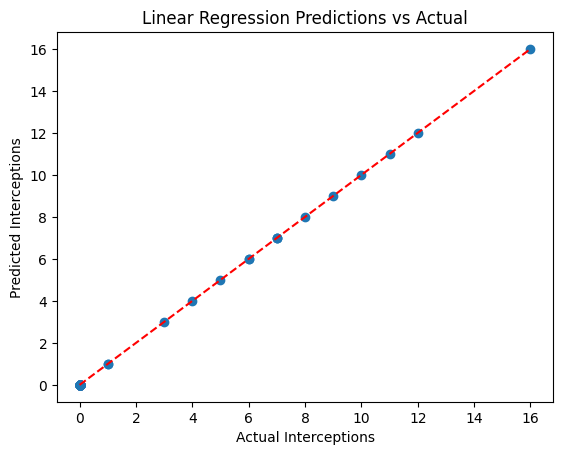

In [13]:
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)

# Plotting
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Interceptions')
plt.ylabel('Predicted Interceptions')
plt.title('Linear Regression Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Line for perfect predictions
plt.show()


## 2. Doing the SHAP Analysis

c:\Codespace\Current Research Areas in ST\Current-Research-Areas-in-ST-MCI-\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


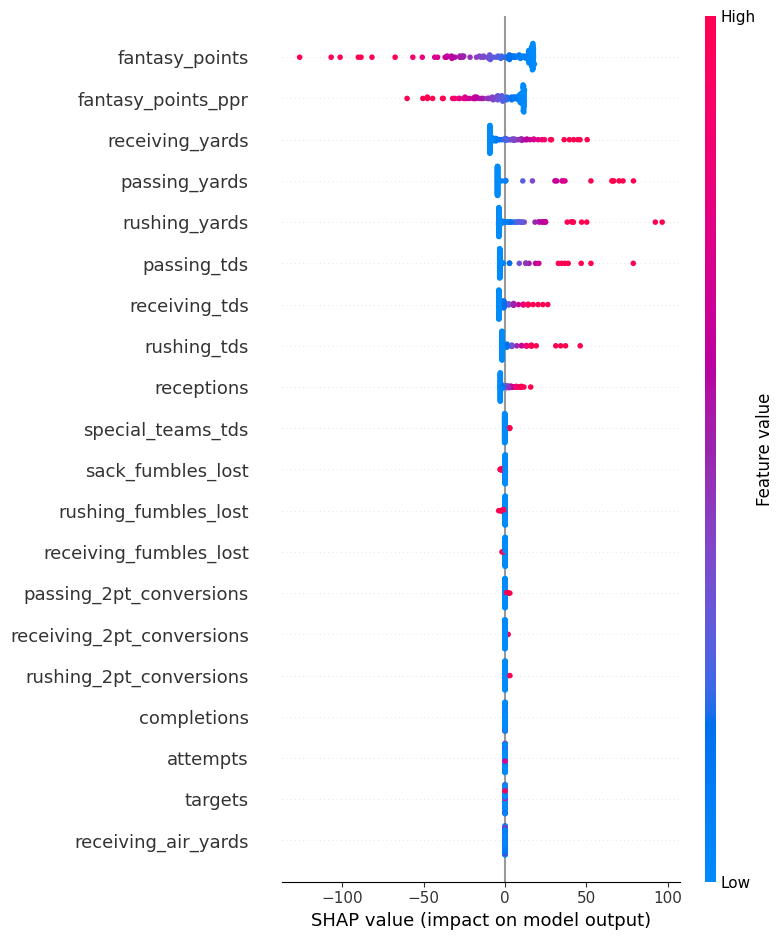

In [5]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values
shap_values = explainer(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test)


#### TASK: So how can we interpret this now?

write you notes on this here

Can we apply the analysis now on a specific sample?

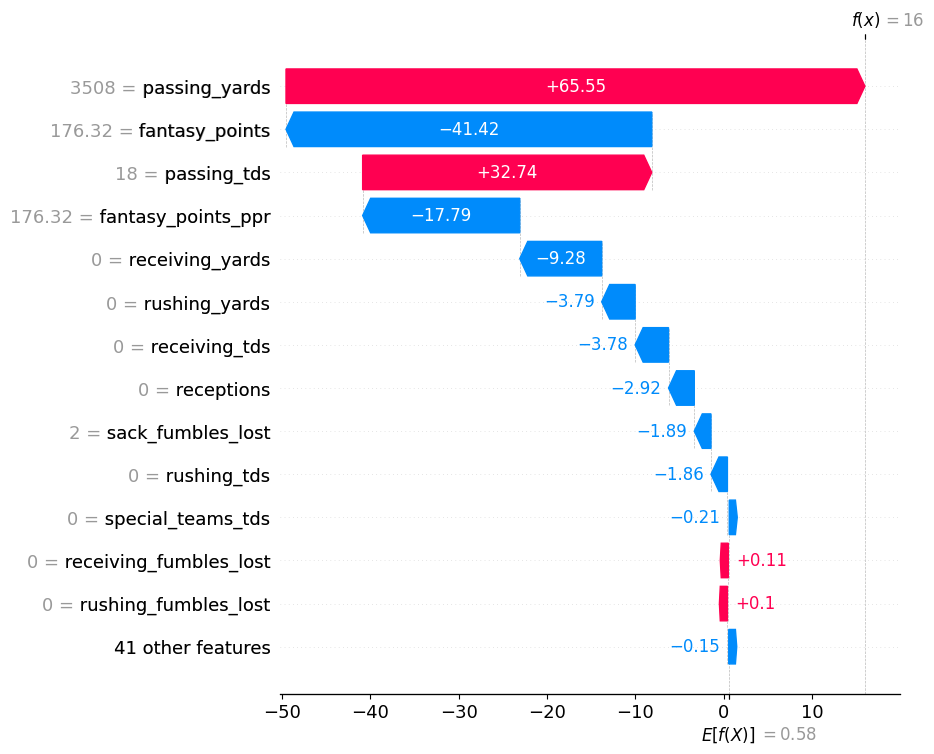

In [14]:
sample_ind= 6  # Change this index to visualize different samples
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

#### TASK: So how can we interpret this now?

write you notes on this here

## 3. Limitation

This is only an introduction for the SHAP values. Interceptions are something that are integer values and not very well distributed. This can be seen here.

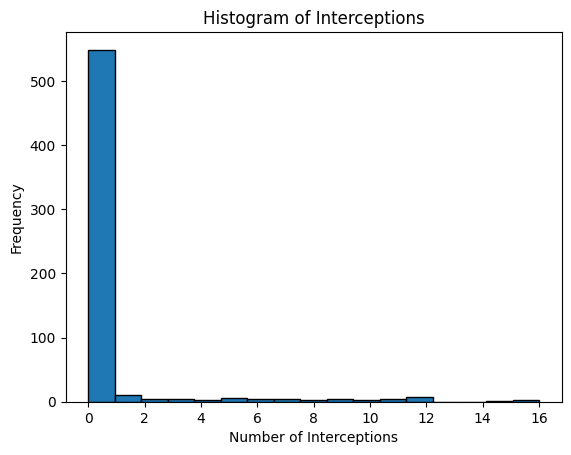

In [18]:
plt.hist(nfl_export['interceptions'], bins=17, edgecolor='black')
plt.xlabel('Number of Interceptions')
plt.ylabel('Frequency')
plt.title('Histogram of Interceptions')
plt.show()


#### TASK 1: Try to do SHAP Analysis on other outputs.  (e.g. Completion, Sack Yards, Fantasy Points)
#### TASK 2: Try to limit the inputs to a subset of variables (e.g drop Fantasy related points)
